<a href="https://colab.research.google.com/github/Dhanush-sai-reddy/llm-runtime-local/blob/main/Deepseek%20mHC%20vs%20standard%20residual%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 146.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 MB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optax 0.2.6 requires jax>=0.5.3, but you have jax 0.4.30 which is incompatible.
optax 0.2.6 requires jaxlib>=0.5.3, but you have jaxlib 0.4.30 which is incompatible.
flax 0.11.2 requires jax>=0.6.0, but you have jax 0.4.30 which is incompatible.
orbax-checkpoint 0.11.32 requires jax>=0.6.0, but you have jax 0.4.30 which is incompatible.


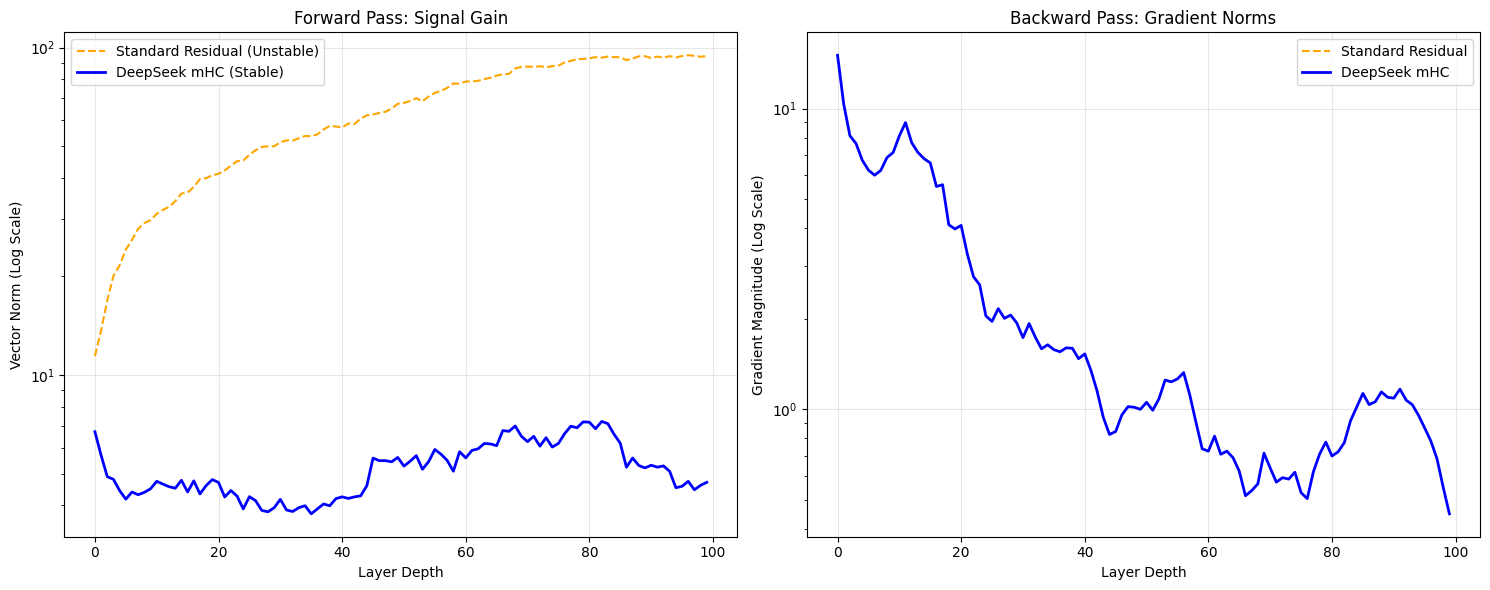

In [ ]:
#installs and imports..
!pip install --upgrade"jax[cuda12_pip]==0.4.30" "jaxlib==0.4.30" matplotlib --quiet

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# 2. mHC Projection (Birkhoff Polytope) CORE
@jax.jit
def sinkhorn_knopp(A, iters=20):
    P = jnp.exp(A - jnp.max(A))
    for _ in range(iters):
        P /= (P.sum(axis=1, keepdims=True) + 1e-8)
        P /= (P.sum(axis=0, keepdims=True) + 1e-8)
    return P

# 3. Memory-Efficient Simulation Engine.
def build_simulation(method='mhc', depth=100, dim=128):
    def step(x, params):
        w_mix, w_proc = params
        if method == 'standard':
            # y = x + f(x)
            next_x = x + jnp.tanh(jnp.dot(x, w_proc))
        else:
            # y = Ax + f(x)
            A = sinkhorn_knopp(w_mix)
            next_x = jnp.dot(A, x) + jnp.tanh(jnp.dot(x, w_proc))

        # Carry the new x, and output its norm for plotting
        return next_x, jnp.linalg.norm(next_x)

    return step

def run_test(method, depth=100, dim=128):
    key = jax.random.PRNGKey(2026)
    x_init = jax.random.normal(key, (dim,))

    # Weights: w_mix is for mHC, w_proc is for the layer logic
    w_mix_all = jax.random.normal(key, (depth, dim, dim))
    w_proc_all = jax.random.normal(key, (depth, dim, dim)) * 0.1

    step_fn = build_simulation(method, depth, dim)

    # jax.lax.scan prevents RAM bloat by reusing memory addresses for each layer
    # uses same amount of RAM for 100 or 1000 layers
    _, magnitudes = jax.lax.scan(step_fn, x_init, (w_mix_all, w_proc_all))

    # Gradient calculation
    def final_loss(proc_weights, mix_weights):
        last_x, _ = jax.lax.scan(step_fn, x_init, (mix_weights, proc_weights))
        return jnp.sum(last_x**2)

    grad_fn = jax.grad(final_loss, argnums=1)
    grads = grad_fn(w_proc_all, w_mix_all)
    grad_norms = jnp.linalg.norm(grads, axis=(1, 2))

    return magnitudes, grad_norms

# 4. Execute Comparison
depth = 100
m_std, g_std = run_test('standard', depth)
m_mhc, g_mhc = run_test('mhc', depth)

# 5. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Forward Pass: Signal Magnitude
ax1.plot(m_std, label='Standard Residual (Unstable)', color='orange', linestyle='--')
ax1.plot(m_mhc, label='DeepSeek mHC (Stable)', color='blue', linewidth=2)
ax1.set_yscale('log')
ax1.set_title('Forward Pass: Signal Gain')
ax1.set_xlabel('Layer Depth')
ax1.set_ylabel('Vector Norm (Log Scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Backward Pass: Gradient Health
ax2.plot(g_std, label='Standard Residual', color='orange', linestyle='--')
ax2.plot(g_mhc, label='DeepSeek mHC', color='blue', linewidth=2)
ax2.set_yscale('log')
ax2.set_title('Backward Pass: Gradient Norms')
ax2.set_xlabel('Layer Depth')
ax2.set_ylabel('Gradient Magnitude (Log Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# AS we can see we cant see the --- standard residual cause its tiny (10^-5 kinda)